# Multilayer fully-connected network

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
#cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar_train['overfeat']
y = cifar_train['labels']
names = cifar_train['names']
#pixels = cifar_train['pixels'].astype(np.float32)
#pixels = pixels / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
#print('pixels:', pixels.shape, pixels.dtype)
print('names:', names)

X: (5000, 4096) float32
y: (5000,) int64
names: ['truck' 'car' 'airplane' 'ship']


# first task: 
Input layer with the 4,096 OverFeat features.

In [3]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=4000, test_size=1000, random_state=0, stratify=y)
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)


In [4]:
# Split data into train/validation sets
X_tr2, X_valid2, y_tr2, y_valid2 = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)
print('Train set:', X_tr2.shape, y_tr2.shape)
print('Valid set:', X_valid2.shape, y_valid2.shape)

Train set: (3200, 4096) (3200,)
Valid set: (800, 4096) (800,)


In [5]:
# Rescale input data
scaler = StandardScaler()
X_tr2 = scaler.fit_transform(X_tr2)
X_valid2 = scaler.transform(X_valid2)
X_te = scaler.transform(X_te)

In [6]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

##  Create and train a multilayer network

In [7]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096]) #Input layer 4096 OverFeat features 
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Hidden layer with 64 units & ReLU
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # 64 units & ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Apply dropout
    training = tf.placeholder(dtype=tf.bool)
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=training)
        #hidden, rate=0.5, seed=0, training=False) Variant tried but not better 
        #hidden, rate=0.5, seed=0, training=training)
          
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None, # Output 4 units, No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights of the first hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))     
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # L2 regularization
    #L2 term
    l2_term = tf.nn.l2_loss(W1)
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    # Loss function
    loss = mean_ce + alpha * l2_term
    # Training operation
    train_op = gd.minimize(loss)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Last Epoch 50 - valid: 0.856 train: 0.927 (mean)
Test accuracy: 0.830


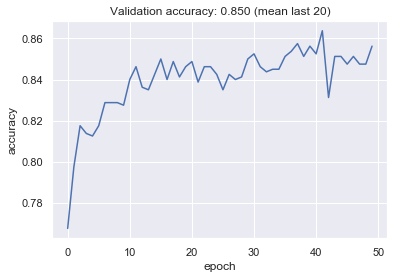

In [8]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        # Get batches of data
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01, # Learning rate
                training: True, # Apply dropout
                alpha: 0.1 # Regularization strength
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid2,
            y: y_valid2,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        #print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
        #    epoch+1, valid_acc, np.mean(batch_acc)))
 

    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False # Do not apply dropout        
    })
    print('Last Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
    print('Test accuracy: {:.3f}'.format(test_acc))
        
    # Weights of the hidden layer
    weights_hidden = W1.eval()

# Plot accuracy values
plt.plot(valid_acc_values)
#plt.plot(batch_acc)
plt.title('Validation accuracy: {:.3f} (mean last 20)'.format(
    np.mean(valid_acc_values[-20:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [9]:
# Grid search
# Parameter tuned
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid({
    'alpha': [0.00005,0.00010,0.00020,0.00030,0.00040,0.00050],  # Regularization strength
    'lr': [0.05,0.06,0.07]              # Learning rate
})

test_scores = []

# loop ----
for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))    
    
    # Validation accuracy
    valid_acc_values = []

    with tf.Session(graph=graph) as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        # Set seed
        np.random.seed(0)

        # Train several epochs
        for epoch in range(50):
            # Accuracy values (train) after each batch
            batch_acc = []

            # Get batches of data
            for X_batch, y_batch in get_batches(X_tr2, y_tr2, 64):
                # Run training and evaluate accuracy
                _, acc_value = sess.run([train_op, accuracy], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: params_dict['lr'], # Learning rate
                    training: True, # Apply dropout
                    alpha: params_dict['alpha'] # Regularization strength
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)

            # Evaluate validation accuracy
            valid_acc = sess.run(accuracy, feed_dict={
                X: X_valid2,
                y: y_valid2,
                training: False # Do not apply dropout
                })
            valid_acc_values.append(valid_acc)

            # Print progress
            #print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            #    epoch+1, valid_acc, np.mean(batch_acc)))


        # Evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_te,
            y: y_te,
            training: False # Do not apply dropout        
        })
        print('Last Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        print('Test accuracy: {:.3f}'.format(test_acc))
   
    # Get train/test scores   
    params_dict['Valid_accuracy'] = valid_acc
    params_dict['Test_accuracy'] = test_acc  

     # Save result
    test_scores.append(params_dict)
#Loop End---
print('done')

Combination 1/18
Last Epoch 50 - valid: 0.842 train: 0.971 (mean)
Test accuracy: 0.836
Combination 2/18
Last Epoch 50 - valid: 0.840 train: 0.974 (mean)
Test accuracy: 0.836
Combination 3/18
Last Epoch 50 - valid: 0.836 train: 0.967 (mean)
Test accuracy: 0.840
Combination 4/18
Last Epoch 50 - valid: 0.839 train: 0.971 (mean)
Test accuracy: 0.826
Combination 5/18
Last Epoch 50 - valid: 0.837 train: 0.971 (mean)
Test accuracy: 0.835
Combination 6/18
Last Epoch 50 - valid: 0.834 train: 0.973 (mean)
Test accuracy: 0.820
Combination 7/18
Last Epoch 50 - valid: 0.850 train: 0.969 (mean)
Test accuracy: 0.833
Combination 8/18
Last Epoch 50 - valid: 0.837 train: 0.968 (mean)
Test accuracy: 0.832
Combination 9/18
Last Epoch 50 - valid: 0.836 train: 0.962 (mean)
Test accuracy: 0.836
Combination 10/18
Last Epoch 50 - valid: 0.844 train: 0.973 (mean)
Test accuracy: 0.830
Combination 11/18
Last Epoch 50 - valid: 0.840 train: 0.970 (mean)
Test accuracy: 0.823
Combination 12/18
Last Epoch 50 - valid: 

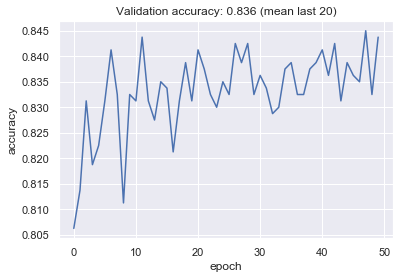

In [10]:
# Plot accuracy values
plt.plot(valid_acc_values)
#plt.plot(batch_acc)
plt.title('Validation accuracy: {:.3f} (mean last 20)'.format(
    np.mean(valid_acc_values[-20:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
# Create DataFrame with sorted accuracy
test_scores_df=pd.DataFrame(test_scores)
df1=test_scores_df.sort_values(by='Test_accuracy', ascending=False)
df1.head(9)

,Test_accuracy,Valid_accuracy,alpha,lr
2,0.840,0.83625,0.00005,0.07
12,0.838,0.84250,0.00040,0.05
0,0.836,0.84250,0.00005,0.05
8,0.836,0.83625,0.00020,0.07
11,0.836,0.83875,0.00030,0.07
1,0.836,0.84000,0.00005,0.06
16,0.835,0.84000,0.00050,0.06
4,0.835,0.83750,0.00010,0.06
17,0.834,0.84375,0.00050,0.07


In [12]:
# Print maximum accuracy
idx = test_scores_df.Test_accuracy.idxmax() # Index of maximum value
max_accuracy = test_scores_df.Test_accuracy[idx]
print('Multilayer fully-connected network accuracy (test set):  {:.3f}'
      .format(max_accuracy))

Multilayer fully-connected network accuracy (test set):  0.840


# Save Result

In [13]:
# Load data & Save Results
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.833
6          fc nn          0.839
7            cnn          0.816


In [14]:
Result_df.iloc[6,1]=max_accuracy
print(Result_df.head(9))
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.833
6          fc nn          0.840
7            cnn          0.816
